In [1]:
import sys
from pathlib import Path

# adding project root to sys.path
repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from models import ARIMAModel, ARIMAXModel, SARIMAXModel, evaluate_forecast
from models.rolling_cv import RollingCV



In [ ]:
pogoh_data_22 = "../processed_data/ready/dataset_v1_pogoh_weather.csv"

In [4]:
pogoh_22_df = pd.read_csv(pogoh_data_22)

In [5]:
pogoh_22_df.head()

,date,trip_count,temp_max,temp_min,temp_mean,precip,precipitation_hours,wind_speed,wind_gusts_10m_max,wind_direction_10m_dominant,...,month_cos,dow_sin,dow_cos,trip_count_lag_1,trip_count_lag_7,trip_count_lag_14,trip_count_rolling_mean_7,trip_count_rolling_std_7,trip_count_rolling_mean_14,trip_count_rolling_std_14
0,2022-05-01,4.0,20.0,10.1,15.0,27.4,13.0,18.4,38.2,152,...,-0.866025,-0.781831,0.623490,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-02,98.0,18.2,10.3,13.6,0.0,0.0,16.9,36.4,277,...,-0.866025,0.000000,1.000000,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-03,21.0,24.3,9.3,16.1,15.6,9.0,15.8,37.8,116,...,-0.866025,0.781831,0.623490,98.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-04,44.0,17.1,12.8,15.9,1.7,8.0,18.3,39.6,287,...,-0.866025,0.974928,-0.222521,21.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-05,104.0,20.3,8.6,14.9,0.2,2.0,10.5,25.2,54,...,-0.866025,0.433884,-0.900969,44.0,NaN,NaN,NaN,NaN,NaN,NaN


##  Prepare data for modeling

In [6]:
# dataset info
pogoh_22_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         1280 non-null   object 
 1   trip_count                   1249 non-null   float64
 2   temp_max                     1280 non-null   float64
 3   temp_min                     1280 non-null   float64
 4   temp_mean                    1280 non-null   float64
 5   precip                       1280 non-null   float64
 6   precipitation_hours          1280 non-null   float64
 7   wind_speed                   1280 non-null   float64
 8   wind_gusts_10m_max           1280 non-null   float64
 9   wind_direction_10m_dominant  1280 non-null   int64  
 10  temp_range                   1280 non-null   float64
 11  is_rainy                     1280 non-null   int64  
 12  is_extreme_heat              1280 non-null   int64  
 13  is_extreme_cold   

In [7]:
# check for missing values
pogoh_22_df.isnull().sum()

date                            0
trip_count                     31
temp_max                        0
temp_min                        0
temp_mean                       0
precip                          0
precipitation_hours             0
wind_speed                      0
wind_gusts_10m_max              0
wind_direction_10m_dominant     0
temp_range                      0
is_rainy                        0
is_extreme_heat                 0
is_extreme_cold                 0
is_extreme_weather              0
day_of_week                     0
month                           0
is_weekend                      0
is_holiday                      0
day_of_year                     0
week_of_year                    0
month_sin                       0
month_cos                       0
dow_sin                         0
dow_cos                         0
trip_count_lag_1               31
trip_count_lag_7               37
trip_count_lag_14              44
trip_count_rolling_mean_7      43
trip_count_rol

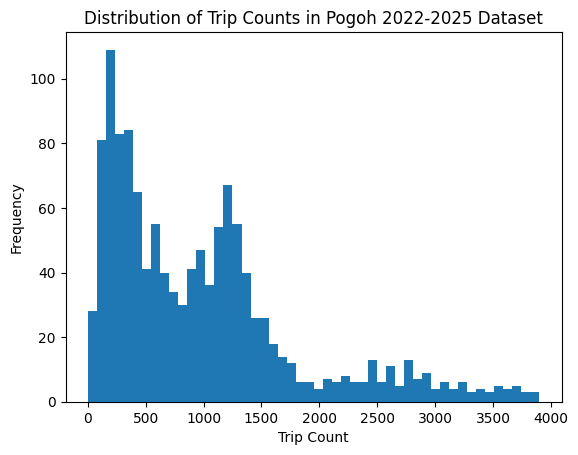

In [8]:
# trip count distribution
plt.hist(pogoh_22_df['trip_count'], bins=50)
plt.xlabel('Trip Count')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Counts in Pogoh 2022-2025 Dataset')
plt.show()

In [9]:
# fill missing values in trip_count
df_copy = pogoh_22_df.copy()
df_copy['trip_count'] = df_copy['trip_count'].fillna(method='ffill').fillna(method='bfill')


/var/folders/lr/7kcjd0991tsdqk5nrlr9gc1w0000gn/T/ipykernel_6124/4158119210.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy['trip_count'] = df_copy['trip_count'].fillna(method='ffill').fillna(method='bfill')


In [10]:
df_copy.isnull().sum()

date                            0
trip_count                      0
temp_max                        0
temp_min                        0
temp_mean                       0
precip                          0
precipitation_hours             0
wind_speed                      0
wind_gusts_10m_max              0
wind_direction_10m_dominant     0
temp_range                      0
is_rainy                        0
is_extreme_heat                 0
is_extreme_cold                 0
is_extreme_weather              0
day_of_week                     0
month                           0
is_weekend                      0
is_holiday                      0
day_of_year                     0
week_of_year                    0
month_sin                       0
month_cos                       0
dow_sin                         0
dow_cos                         0
trip_count_lag_1               31
trip_count_lag_7               37
trip_count_lag_14              44
trip_count_rolling_mean_7      43
trip_count_rol

In [11]:
# fill NaNs with the same-day trip_count
# avoiding to use a global mean and keeps the signal aligned to the current day
lag_cols = ['trip_count_lag_1', 'trip_count_lag_7', 'trip_count_lag_14']
for col in lag_cols:
    df_copy[col] = df_copy[col].fillna(df_copy['trip_count'])

df_copy[lag_cols].isnull().sum()

trip_count_lag_1     0
trip_count_lag_7     0
trip_count_lag_14    0
dtype: int64

In [ ]:
# parse dates safely
if not pd.api.types.is_datetime64_any_dtype(df_copy['date']):
    df_dates = pd.to_datetime(df_copy['date'], errors='coerce')
else:
    df_dates = df_copy['date']

ordered = df_copy.assign(__date=df_dates).sort_values('__date')

# shift by 1 day so current day's rolling stats use only prior days
s = ordered['trip_count']
s_shift = s.shift(1)
# compute rolling statistics
roll_mean_7 = s_shift.rolling(window=7, min_periods=1).mean()
roll_std_7 = s_shift.rolling(window=7, min_periods=1).std(ddof=0)
roll_mean_14 = s_shift.rolling(window=14, min_periods=1).mean()
roll_std_14 = s_shift.rolling(window=14, min_periods=1).std(ddof=0)

# re-align to original row order
roll_mean_7 = roll_mean_7.sort_index()
roll_std_7 = roll_std_7.sort_index()
roll_mean_14 = roll_mean_14.sort_index()
roll_std_14 = roll_std_14.sort_index()

# overwrite rolling feature columns to reflect updated trip_count
df_copy['trip_count_rolling_mean_7'] = roll_mean_7
df_copy['trip_count_rolling_std_7'] = roll_std_7
df_copy['trip_count_rolling_mean_14'] = roll_mean_14
df_copy['trip_count_rolling_std_14'] = roll_std_14

# the very first row has no prior day; set remaining NaN (if any) to 0 to avoid leakage
check_cols = [
    'trip_count_rolling_mean_7',
    'trip_count_rolling_std_7',
    'trip_count_rolling_mean_14',
    'trip_count_rolling_std_14'
]
df_copy[check_cols] = df_copy[check_cols].fillna(0)

# sanity check: should be 0 NaNs now
df_copy[check_cols].isnull().sum()

trip_count_rolling_mean_7     0
trip_count_rolling_std_7      0
trip_count_rolling_mean_14    0
trip_count_rolling_std_14     0
dtype: int64

In [13]:
df_copy.isnull().sum()

date                           0
trip_count                     0
temp_max                       0
temp_min                       0
temp_mean                      0
precip                         0
precipitation_hours            0
wind_speed                     0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
temp_range                     0
is_rainy                       0
is_extreme_heat                0
is_extreme_cold                0
is_extreme_weather             0
day_of_week                    0
month                          0
is_weekend                     0
is_holiday                     0
day_of_year                    0
week_of_year                   0
month_sin                      0
month_cos                      0
dow_sin                        0
dow_cos                        0
trip_count_lag_1               0
trip_count_lag_7               0
trip_count_lag_14              0
trip_count_rolling_mean_7      0
trip_count_rolling_std_7       0
trip_count

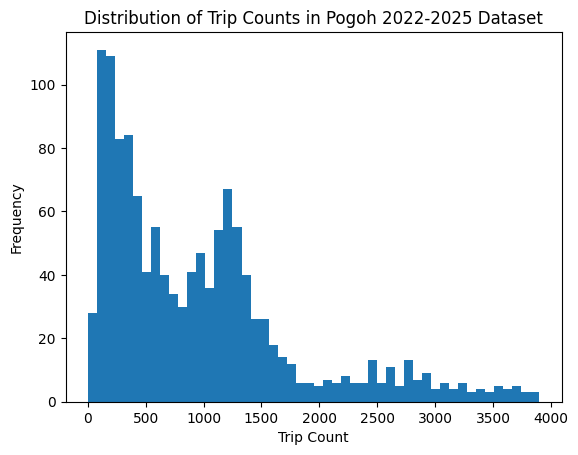

In [14]:
# trip count distribution
plt.hist(df_copy['trip_count'], bins=50)
plt.xlabel('Trip Count')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Counts in Pogoh 2022-2025 Dataset')
plt.savefig("distribution of trip.png", dpi=300, bbox_inches='tight')
plt.show()

In [15]:
df_copy.head()

,date,trip_count,temp_max,temp_min,temp_mean,precip,precipitation_hours,wind_speed,wind_gusts_10m_max,wind_direction_10m_dominant,...,month_cos,dow_sin,dow_cos,trip_count_lag_1,trip_count_lag_7,trip_count_lag_14,trip_count_rolling_mean_7,trip_count_rolling_std_7,trip_count_rolling_mean_14,trip_count_rolling_std_14
0,2022-05-01,4.0,20.0,10.1,15.0,27.4,13.0,18.4,38.2,152,...,-0.866025,-0.781831,0.623490,4.0,4.0,4.0,0.00,0.000000,0.00,0.000000
1,2022-05-02,98.0,18.2,10.3,13.6,0.0,0.0,16.9,36.4,277,...,-0.866025,0.000000,1.000000,4.0,98.0,98.0,4.00,0.000000,4.00,0.000000
2,2022-05-03,21.0,24.3,9.3,16.1,15.6,9.0,15.8,37.8,116,...,-0.866025,0.781831,0.623490,98.0,21.0,21.0,51.00,47.000000,51.00,47.000000
3,2022-05-04,44.0,17.1,12.8,15.9,1.7,8.0,18.3,39.6,287,...,-0.866025,0.974928,-0.222521,21.0,44.0,44.0,41.00,40.898248,41.00,40.898248
4,2022-05-05,104.0,20.3,8.6,14.9,0.2,2.0,10.5,25.2,54,...,-0.866025,0.433884,-0.900969,44.0,104.0,104.0,41.75,35.442736,41.75,35.442736


### ARIMA Baseline modeling with Rolling CV

ARIMA Rolling CV Metrics: {'RMSE': np.float64(583.821), 'MAE': 391.159, 'MAPE': np.float64(48.434), 'SMAPE': np.float64(37.408)}


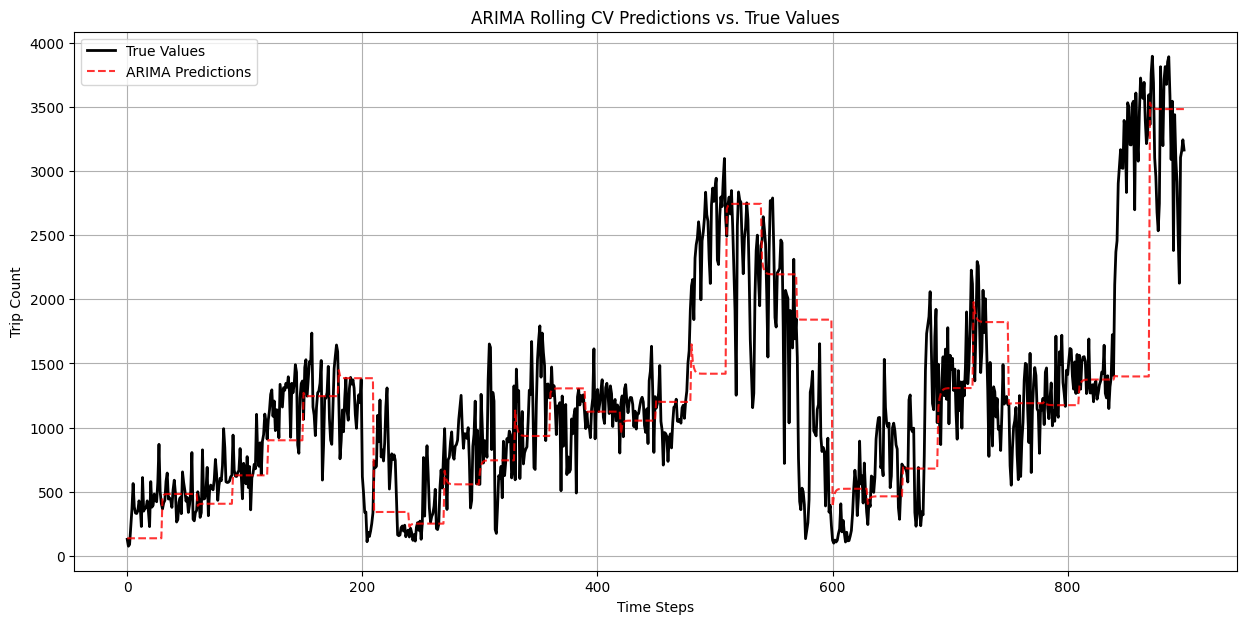

In [16]:
_df = df_copy
y = _df[['date', 'trip_count']].copy()
y['date'] = pd.to_datetime(y['date'], errors='coerce')
y = y.dropna(subset=['date']).sort_values('date').set_index('date')['trip_count'].astype(float)
y = y.asfreq('D').ffill().bfill()

# Rolling CV parms
initial_train_size = 365
test_size = 30
step = 30

cv = RollingCV(initial_train_size, test_size, step)
all_preds = []
all_trues = []

for train_indices, test_indices in cv.split(y):
    train_y = y.iloc[train_indices]
    test_y = y.iloc[test_indices]
    
    arima = ARIMAModel(order=(1, 1, 1)).fit(train_y)
    y_pred = arima.forecast(steps=len(test_y))
    
    all_preds.extend(y_pred)
    all_trues.extend(test_y.values)

metrics = evaluate_forecast(np.array(all_trues), np.array(all_preds))
print("ARIMA Rolling CV Metrics:", {k: round(v, 3) if v == v else v for k, v in metrics.items()})


plt.figure(figsize=(15, 7))
plt.plot(all_trues, label='True Values', color='black', linewidth=2)
plt.plot(all_preds, label='ARIMA Predictions', linestyle='--', alpha=0.8, color='red')
plt.title('ARIMA Rolling CV Predictions vs. True Values')
plt.xlabel('Time Steps')
plt.ylabel('Trip Count')
plt.legend()
plt.grid(True)
plt.show()

### ARIMAX Baseline Modeling with Rolling CV

ARIMAX Rolling CV Metrics: {'RMSE': np.float64(509.299), 'MAE': 347.279, 'MAPE': np.float64(42.612), 'SMAPE': np.float64(37.369)}


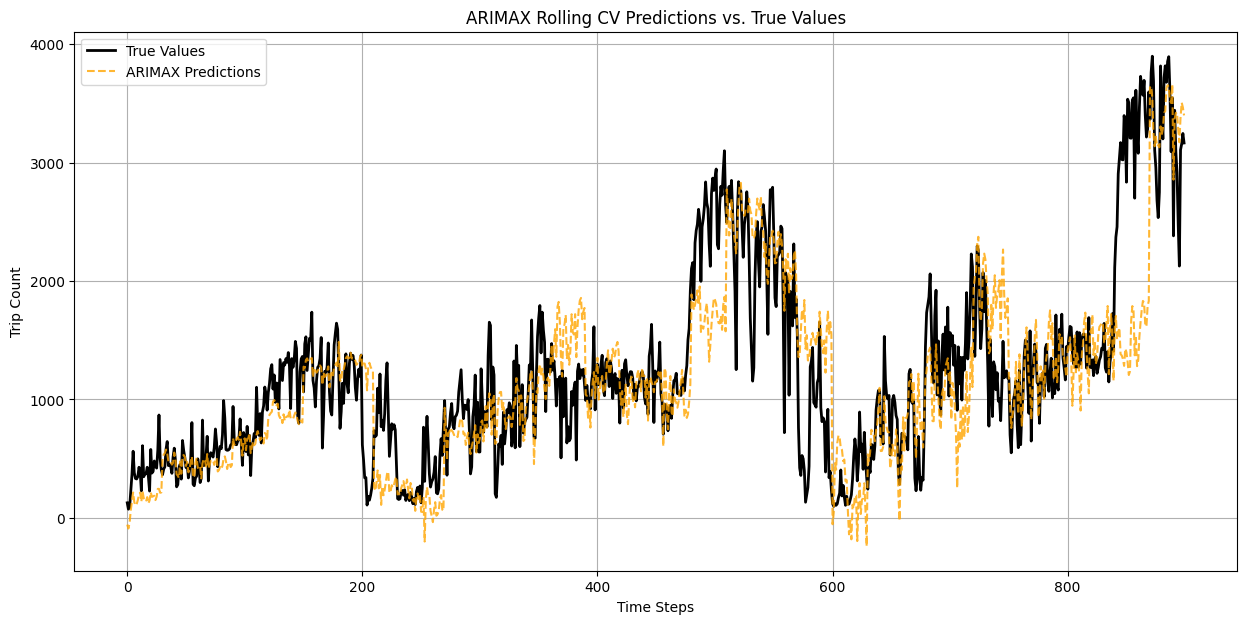

In [17]:
# exogenous variables
exog_cols = [
    'month_sin', 'month_cos', 'dow_sin', 'dow_cos',
    'temp_mean', 'precip', 'precipitation_hours',
    'wind_speed', 'wind_gusts_10m_max', 'temp_range',
    'is_rainy', 'is_weekend', 'is_holiday'
]
_exog = df_copy[['date'] + exog_cols].copy()
_exog['date'] = pd.to_datetime(_exog['date'], errors='coerce')
_exog = _exog.dropna(subset=['date']).sort_values('date').set_index('date')
_exog = _exog.asfreq('D').ffill().bfill()

for bcol in ['is_rainy', 'is_weekend', 'is_holiday']:
    if bcol in _exog.columns:
        _exog[bcol] = _exog[bcol].astype(int)


y_aligned, exog_aligned = y.align(_exog, join='inner', axis=0)

cv_arimax = RollingCV(initial_train_size, test_size, step)
all_preds_arimax = []
all_trues_arimax = []

# scaling
cont_cols = ['temp_mean', 'precip', 'precipitation_hours', 'wind_speed', 'wind_gusts_10m_max', 'temp_range']

for train_indices, test_indices in cv_arimax.split(y_aligned):
    train_y = y_aligned.iloc[train_indices]
    test_y = y_aligned.iloc[test_indices]
    
    exog_train = exog_aligned.iloc[train_indices].copy()
    exog_test = exog_aligned.iloc[test_indices].copy()
    
    scaler = StandardScaler()
    exog_train[cont_cols] = scaler.fit_transform(exog_train[cont_cols])
    exog_test[cont_cols] = scaler.transform(exog_test[cont_cols])

    arimax = ARIMAXModel(order=(1, 1, 1)).fit(train_y, exog=exog_train, maxiter=1000)
    y_pred_arimax = arimax.forecast(steps=len(test_y), exog=exog_test)
    
    all_preds_arimax.extend(y_pred_arimax)
    all_trues_arimax.extend(test_y.values)

metrics_arimax = evaluate_forecast(np.array(all_trues_arimax), np.array(all_preds_arimax))
print("ARIMAX Rolling CV Metrics:", {k: round(v, 3) if v == v else v for k, v in metrics_arimax.items()})


plt.figure(figsize=(15, 7))
plt.plot(all_trues_arimax, label='True Values', color='black', linewidth=2)
plt.plot(all_preds_arimax, label='ARIMAX Predictions', linestyle='--', alpha=0.8, color='orange')
plt.title('ARIMAX Rolling CV Predictions vs. True Values')
plt.xlabel('Time Steps')
plt.ylabel('Trip Count')
plt.legend()
plt.grid(True)
plt.show()

### SARIMAX Baseline Modeling with Rolling CV

SARIMAX Rolling CV Metrics: {'RMSE': np.float64(515.501), 'MAE': 352.625, 'MAPE': np.float64(43.366), 'SMAPE': np.float64(37.82)}


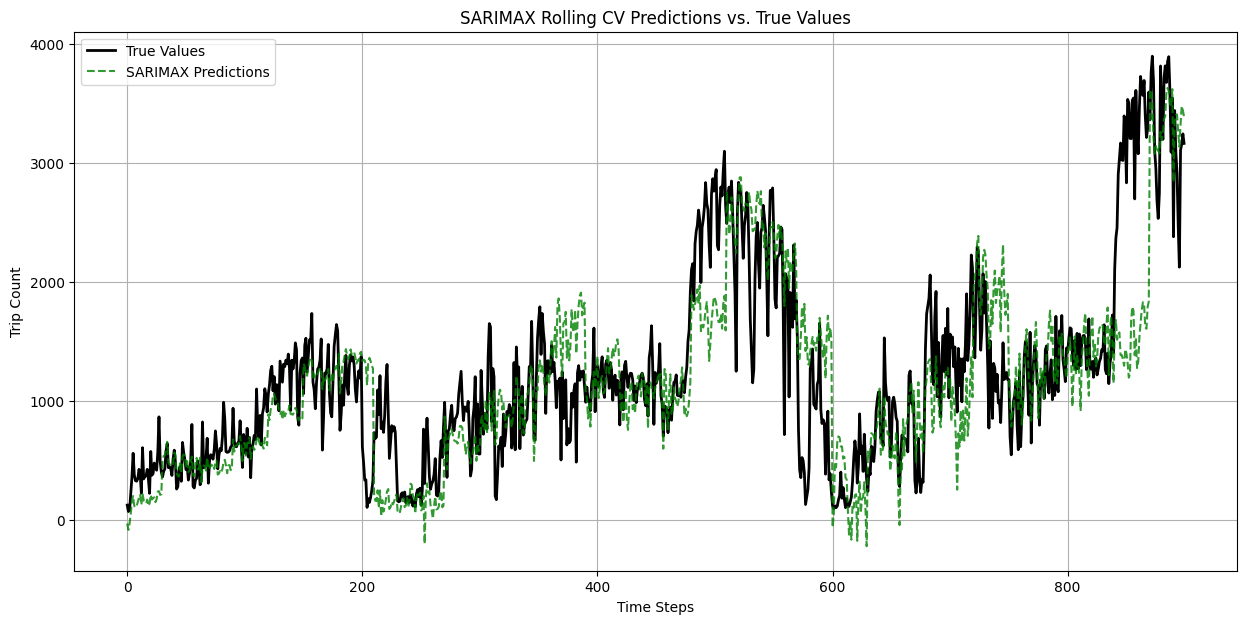

In [ ]:
seasonal_order = (1, 0, 0, 7)

cv_sarimax = RollingCV(initial_train_size, test_size, step)
all_preds_sarimax = []
all_trues_sarimax = []
# scaling
cont_cols = ['temp_mean', 'precip', 'precipitation_hours', 'wind_speed', 'wind_gusts_10m_max', 'temp_range']

for train_indices, test_indices in cv_sarimax.split(y_aligned):
    train_y = y_aligned.iloc[train_indices]
    test_y = y_aligned.iloc[test_indices]
    exog_train = exog_aligned.iloc[train_indices].copy()
    exog_test = exog_aligned.iloc[test_indices].copy()
    
    scaler = StandardScaler()
    exog_train[cont_cols] = scaler.fit_transform(exog_train[cont_cols])
    exog_test[cont_cols] = scaler.transform(exog_test[cont_cols])
    
    # Fit model with seasonal components
    sarimax = SARIMAXModel(order=(1, 1, 1), seasonal_order=seasonal_order).fit(train_y, exog=exog_train, maxiter=1000, disp=False)
    y_pred_sarimax = sarimax.forecast(steps=len(test_y), exog=exog_test)
    
    all_preds_sarimax.extend(y_pred_sarimax)
    all_trues_sarimax.extend(test_y.values)

metrics_sarimax = evaluate_forecast(np.array(all_trues_sarimax), np.array(all_preds_sarimax))
print("SARIMAX Rolling CV Metrics:", {k: round(v, 3) if v == v else v for k, v in metrics_sarimax.items()})


plt.figure(figsize=(15, 7))
plt.plot(all_trues_sarimax, label='True Values', color='black', linewidth=2)
plt.plot(all_preds_sarimax, label='SARIMAX Predictions', linestyle='--', alpha=0.8, color='green')
plt.title('SARIMAX Rolling CV Predictions vs. True Values')
plt.xlabel('Time Steps')
plt.ylabel('Trip Count')
plt.legend()
plt.grid(True)
plt.show()